[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/028_pytorch_nn/pytorch_nn.ipynb)

# Pytorch - Redes Neuronales

In [ ]:
import torch
import numpy as np
import os

from matplotlib import pyplot as plt

from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from matplotlib import pyplot
import torchvision # torch package for vision related things
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from tqdm import tqdm  # For nice progress bar!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_dataset = datasets.EMNIST(root="EMNIST/processed/training.pt", split='letters', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.EMNIST(root="EMNIST/processed/test.pt", split='letters', train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
len(train_dataset), len(test_dataset)

(124800, 20800)

In [ ]:
#X_TRAIN, X_TEST, y_TRAIN, y_TEST = X[:60000] / 255., X[60000:] / 255., Y[:60000].astype(np.int), Y[60000:].astype(np.int)
Y_TRAIN = train_dataset.targets
X_TRAIN = train_dataset.data/ 255

Y_TEST = test_dataset.targets
X_TEST = test_dataset.data/ 255

In [ ]:
X_TRAIN.shape

torch.Size([124800, 28, 28])

In [ ]:
X_TRAIN = torch.flatten(X_TRAIN, start_dim=1)
X_TRAIN.shape,Y_TRAIN.shape

X_TEST = torch.flatten(X_TEST, start_dim=1)
X_TEST.shape,Y_TRAIN.shape

(torch.Size([20800, 784]), torch.Size([124800]))

In [ ]:
X_TRAIN = X_TRAIN.numpy()
Y_TRAIN = Y_TRAIN.numpy()

X_TEST = X_TEST.numpy()
Y_TEST = Y_TEST.numpy()

In [ ]:
from sklearn.metrics import accuracy_score

def displayData(X, example_width=None, figsize=(10, 10)):
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

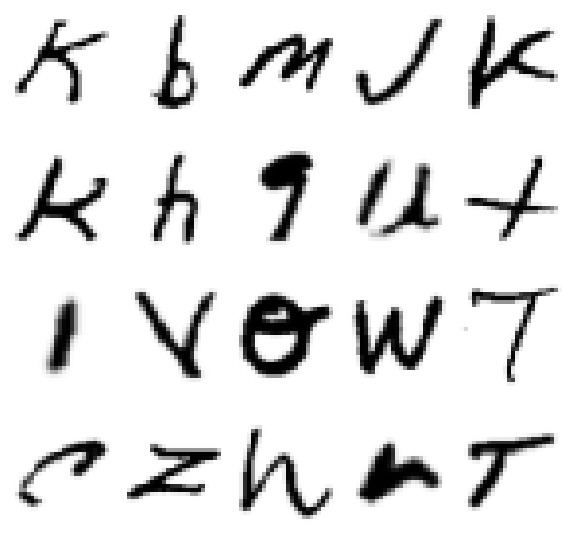

In [ ]:
rand_indices = np.random.choice(784, 20, replace=False)
sel = X_TRAIN[rand_indices, :]

displayData(sel)

In [ ]:
class Model(torch.nn.Module):
    
    # constructor
    def __init__(self, D_in, H, D_out):
        
        # llamamos al constructor de la clase madre
        super(Model, self).__init__()
        
        # definimos nuestras capas
        self.fc1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(H, D_out)
        
    # lógica para calcular las salidas de la red
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
X_t = torch.from_numpy(X_TRAIN).float().cuda()
Y_t = torch.from_numpy(Y_TRAIN).long().cuda()

In [ ]:
type(X_t), X_t.dtype

(torch.Tensor, torch.float32)

In [ ]:
model = Model(784, 50, 52)
outputs = model(torch.randn(64, 784))
outputs.shape

torch.Size([64, 52])

In [ ]:
model.to("cuda")

Model(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=52, bias=True)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

epochs = 1000
log_each = 10
l = []
model.train()
y_pred = 0
for e in range(1, epochs+1): 
    
    # forward
    y_pred = model(X_t)

    # loss
    loss = criterion(y_pred, Y_t)
    l.append(loss.item())
    
    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()
    
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")
        
y_pred = evaluate(torch.from_numpy(X_TEST).float().cuda())
accuracy_score(Y_TEST, y_pred.cpu().numpy())

Epoch 10/1000 Loss 3.37708
Epoch 20/1000 Loss 2.89199
Epoch 30/1000 Loss 2.55251
Epoch 40/1000 Loss 2.31124
Epoch 50/1000 Loss 2.14783
Epoch 60/1000 Loss 2.00281
Epoch 70/1000 Loss 1.89149
Epoch 80/1000 Loss 1.79655
Epoch 90/1000 Loss 1.72300
Epoch 100/1000 Loss 1.65294
Epoch 110/1000 Loss 1.59136
Epoch 120/1000 Loss 1.53839
Epoch 130/1000 Loss 1.49069
Epoch 140/1000 Loss 1.44996
Epoch 150/1000 Loss 1.41225
Epoch 160/1000 Loss 1.37760
Epoch 170/1000 Loss 1.34375
Epoch 180/1000 Loss 1.31433
Epoch 190/1000 Loss 1.28679
Epoch 200/1000 Loss 1.26121
Epoch 210/1000 Loss 1.23763
Epoch 220/1000 Loss 1.21574
Epoch 230/1000 Loss 1.19505
Epoch 240/1000 Loss 1.17563
Epoch 250/1000 Loss 1.15676
Epoch 260/1000 Loss 1.13900
Epoch 270/1000 Loss 1.12475
Epoch 280/1000 Loss 1.10844
Epoch 290/1000 Loss 1.09321
Epoch 300/1000 Loss 1.07861
Epoch 310/1000 Loss 1.06569
Epoch 320/1000 Loss 1.05237
Epoch 330/1000 Loss 1.04055
Epoch 340/1000 Loss 1.02876
Epoch 350/1000 Loss 1.01892
Epoch 360/1000 Loss 1.00728
E

0.5840865384615385

In [ ]:
y_pred.shape

torch.Size([20800])

Metricas

In [ ]:
def metric(y_test, y_evalaue):
    TP = np.sum((y_pred == 1) & (y_evalaue == 1)) 
    TN = np.sum((y_pred == 0) & (y_evalaue == 0)) 
    FP = np.sum((y_pred == 1) & (y_evalaue == 0))
    FN = np.sum((y_pred == 0) & (y_evalaue == 1))
    CM = [[TN, FP],[FN, TP]]
    return CM
    
def precision(y_pred, y):
    TP = np.sum((y_pred == 1) & (y == 1)) 
    FP = np.sum((y_pred == 1) & (y == 0))
    return TP / (TP + FP)

def recall(y_pred, y):
    TP = np.sum((y_pred == 1) & (y == 1)) 
    FN = np.sum((y_pred == 0) & (y == 1))
    return TP / (TP + FN)

In [ ]:
X_TRAIN = X_TRAIN.astype(np.object)
Y_TRAIN = Y_TRAIN.astype(np.object)

X_TEST = X_TEST.astype(np.object)
Y_TEST = Y_TEST.astype(np.object)

In [ ]:
y_train_e = (Y_TRAIN == 'e').astype(np.int)
y_test_e = (Y_TEST == 'e').astype(np.int)

In [ ]:
y_pred = y_pred.to("cpu").numpy()

In [ ]:
y_pred.shape,y_test_e.shape

((20800,), (20800,))

In [ ]:
m2x2 = metric(y_pred, y_test_e)
m2x2

[[0, 51], [0, 0]]

In [ ]:
recall(y_pred, Y_TEST)

1.0

In [ ]:
precision(y_pred, Y_TEST)

1.0

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_e, y_pred)

0.0

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_e, y_pred).shape

(27, 27)